# Binary Classification with PyTorch

In [models](MODELS.md) section for demonstration purposes a regression model was created an trained.



In [78]:
import torch
import torch.nn as nn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## Getting Data

In [80]:
X, y = make_circles(n_samples=1000, noise=0.04, random_state=7)

X.shape, y.shape

((1000, 2), (1000,))

In [81]:
X[:5], y[:5]

(array([[-0.75876333, -0.27344342],
        [-0.47799317, -0.8753975 ],
        [-0.97185957, -0.24912226],
        [-0.66952837, -0.50331704],
        [-0.90720545,  0.40643155]]),
 array([1, 0, 0, 1, 0], dtype=int64))

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [83]:
import pandas as pd
df_circles = pd.DataFrame({"X1": X[:, 0],
                           "X2": X[:, 1],
                           "label": y})

df_circles.head()

,X1,X2,label
0,-0.758763,-0.273443,1
1,-0.477993,-0.875398,0
2,-0.971860,-0.249122,0
3,-0.669528,-0.503317,1
4,-0.907205,0.406432,0


In [84]:
df_circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

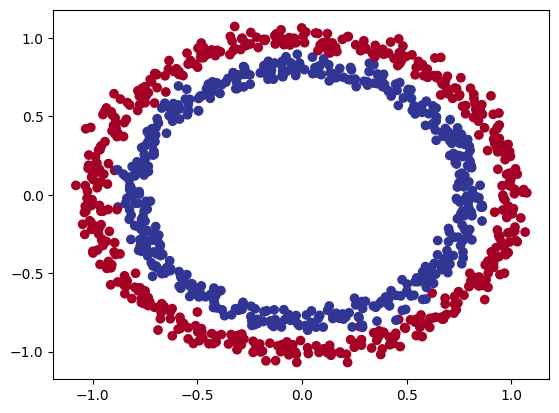

In [85]:
plt.plot()
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [86]:
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

In [87]:
# Create model class
class BinaryClassificationModelv1(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_1 = nn.Linear(in_features=2, out_features=8)
        self.linear_2 = nn.Linear(in_features=8, out_features=1)
    
    def forward(self, x):
        # input -> linear_1 -> linear_2 -> output
        return self.linear_2(self.linear_1(x))
    
torch.manual_seed(7)
model0 = BinaryClassificationModelv1()

model0.state_dict()

OrderedDict([('linear_1.weight',
              tensor([[ 0.0494, -0.4260],
                      [ 0.2252,  0.2219],
                      [-0.3779, -0.1060],
                      [-0.4142,  0.1835],
                      [-0.1905,  0.4968],
                      [ 0.5020,  0.0720],
                      [-0.3015, -0.4153],
                      [-0.0777, -0.1990]])),
             ('linear_1.bias',
              tensor([ 0.3117, -0.6038,  0.6646, -0.5547,  0.5415, -0.1228,  0.3637,  0.2756])),
             ('linear_2.weight',
              tensor([[ 0.0148,  0.0659,  0.2685,  0.0909,  0.1876, -0.2735,  0.2517,  0.1217]])),
             ('linear_2.bias', tensor([0.0896]))])

In [88]:
# Alternative model creation syntax - useful for simple models

torch.manual_seed(7)
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
)

# As you can see generated model is the same.
print(model0.state_dict())

# Take model to specified device
model0.to(device)

print("The model is in device:", next(model0.parameters()).device)

OrderedDict([('0.weight', tensor([[ 0.0494, -0.4260],
        [ 0.2252,  0.2219],
        [-0.3779, -0.1060],
        [-0.4142,  0.1835],
        [-0.1905,  0.4968],
        [ 0.5020,  0.0720],
        [-0.3015, -0.4153],
        [-0.0777, -0.1990]])), ('0.bias', tensor([ 0.3117, -0.6038,  0.6646, -0.5547,  0.5415, -0.1228,  0.3637,  0.2756])), ('1.weight', tensor([[ 0.0148,  0.0659,  0.2685,  0.0909,  0.1876, -0.2735,  0.2517,  0.1217]])), ('1.bias', tensor([0.0896]))])
The model is in device: cuda:0


In [89]:
# Loss function
# Use BCELoss() when sigmoid applied to outputs
# Use BCEWithLogitsLoss() if sigmoid not applied.
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [90]:
# Calculating accuracy
# Formula: (True Positives + True Negatives) / (All Predictions) * 100

def calc_accuracy(y_true, y_pred):
    tp_tn = torch.eq(y_true, y_pred).sum().item()
    acc = (tp_tn / len(y_true)) * 100

    return acc

In [91]:
# Logit is the raw output of a layer. If a meaningful data is needed, logit should be sent to an activation function.

# Raw logits -> Prediction probabilities -> Prediction label
#            -> apply softmax for binary classification -> round(pred) [0-1]
#            -> apply sigmoid for multiclass classification -> argmax() = index of max probability is the prediction label 

- Model outputs float logits but data has labelled as 0 or 1.
- For binary classification we should apply activation function to these predictions in order to compare directly with true labels.

In [92]:
# Let's se what our model outputs when a prediction made
model0.eval()

with torch.inference_mode():
    y_logits = model0(X_test.to(device))

y_logits[:5]

tensor([[0.7085],
        [0.8423],
        [0.2012],
        [0.2635],
        [0.6067]], device='cuda:0')

In [93]:
y_test[:5]

tensor([1., 0., 0., 1., 1.])

In [94]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.6701],
        [0.6990],
        [0.5501],
        [0.5655],
        [0.6472]], device='cuda:0')

In [95]:
torch.round(y_pred_probs)[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

## Train Loop

In [96]:
torch.manual_seed(7)
torch.cuda.manual_seed(7)

EPOCHS = 100
PAD = len(str(EPOCHS))

# Move data to corresponding device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# For collecting data about training
history_epochs = []
history_loss = []
history_acc = []
history_test_loss = []
history_test_acc = []

for epoch in range(1, EPOCHS+1):
    # set model to train mode
    model0.train()

    # Clean gradients from accumulation
    optimizer.zero_grad()

    # Forward pass
    y_logits = model0(X_train).squeeze() # [800, 1] -> [800]
    y_preds = torch.round(torch.sigmoid(y_logits))

    # Calculate loss and accuracy
    # Loss function BCEWithLogitsLoss() expects logits as input.
    loss = loss_fn(y_logits, y_train)
    acc = calc_accuracy(y_true=y_train, y_pred=y_preds)

    # Backpropagation
    loss.backward()

    # Adjust parameters
    optimizer.step()

    # Testing
    model0.eval()

    with torch.inference_mode():
        # Forward pass
        test_logits = model0(X_test).squeeze() # [200, 1] -> [200]
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = calc_accuracy(y_true=y_test, y_pred=test_preds)

        # Collect data
        history_epochs.append(epoch)
        history_loss.append(loss)
        history_acc.append(acc)
        history_test_loss.append(test_loss)
        history_test_acc.append(test_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:>{PAD}} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch  10 | Train Loss: 0.70567 | Train Acc: 53.25 | Test Loss: 0.69068 | Test Acc: 52.50
Epoch  20 | Train Loss: 0.69818 | Train Acc: 50.00 | Test Loss: 0.69410 | Test Acc: 52.00
Epoch  30 | Train Loss: 0.69610 | Train Acc: 49.75 | Test Loss: 0.69696 | Test Acc: 52.00
Epoch  40 | Train Loss: 0.69529 | Train Acc: 48.75 | Test Loss: 0.69847 | Test Acc: 49.50
Epoch  50 | Train Loss: 0.69483 | Train Acc: 48.38 | Test Loss: 0.69912 | Test Acc: 48.00
Epoch  60 | Train Loss: 0.69449 | Train Acc: 48.88 | Test Loss: 0.69932 | Test Acc: 47.00
Epoch  70 | Train Loss: 0.69421 | Train Acc: 48.62 | Test Loss: 0.69932 | Test Acc: 44.00
Epoch  80 | Train Loss: 0.69399 | Train Acc: 48.12 | Test Loss: 0.69923 | Test Acc: 44.00
Epoch  90 | Train Loss: 0.69379 | Train Acc: 48.12 | Test Loss: 0.69911 | Test Acc: 45.00
Epoch 100 | Train Loss: 0.69363 | Train Acc: 47.75 | Test Loss: 0.69898 | Test Acc: 45.00


In [97]:
X_test[:5]

tensor([[-0.6317, -0.4210],
        [-1.0353, -0.0738],
        [ 0.4968,  0.8805],
        [ 0.3600,  0.7080],
        [-0.3180, -0.7270]], device='cuda:0')

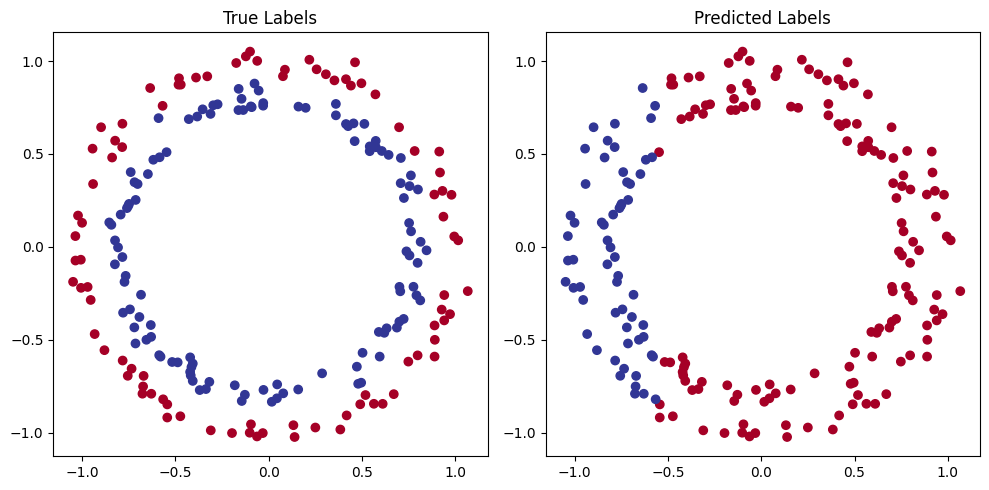

In [98]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("True Labels")
plt.scatter(x=X_test[:, 0].cpu(), y=X_test[:, 1].cpu(), c=y_test.cpu(), cmap=plt.cm.RdYlBu)

plt.subplot(1,2,2)
plt.title("Predicted Labels")
plt.scatter(x=X_test[:, 0].cpu(), y=X_test[:, 1].cpu(), c=test_preds.cpu(), cmap=plt.cm.RdYlBu)

plt.tight_layout()
plt.show()

In [99]:
import requests
from pathlib import Path

FILE_NAME = "helper_functions.py"

if Path(FILE_NAME).is_file():
    print(f"{FILE_NAME} already exists. Skipping downloading.")
else:
    print(f"Started downloading {FILE_NAME}.")
    try:
        request = requests.get(
            "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
        
        with open(FILE_NAME, "wb") as f:
            f.write(request.content)
            print("Download complete.")

    except Exception as e:
        print("An error occurred:", e)

helper_functions.py already exists. Skipping downloading.


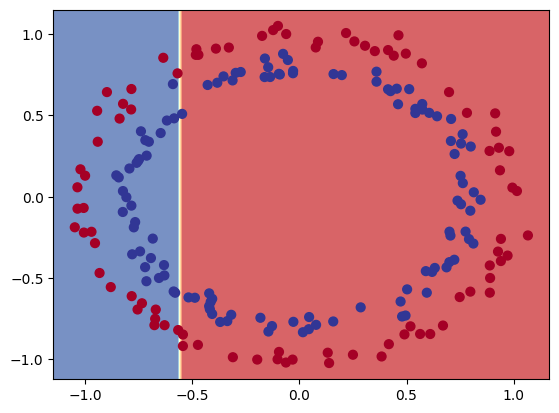

In [100]:
from helper_functions import plot_decision_boundary

plt.figure()
plot_decision_boundary(model=model0, X=X_test, y=y_test)
plt.show()

## Improving Model

- Adding more units
- Adding more layers
- Trying different activation functions
- Trying different optimizers
- Change learning rate
- Choose correct loss function for the problem
- Train for more epochs


You can try all of the above. Buf problem is really clear if you visualize the test results.

**Our model has only linear layers. Linear layers can only represent linear data. But our data is circular.**

**Solution:** We need to implement non-linearity in order to be able to fit non-linear data.

https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

Let's alter the model with adding some non-linearity.

In [116]:
class CircularModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_1 = nn.Linear(in_features=2, out_features=16)
        self.linear_2 = nn.Linear(in_features=16, out_features=16)
        self.linear_3 = nn.Linear(in_features=16, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # !!! Do not activate last layer with relu. !!!
        return self.linear_3(self.relu(self.linear_2(self.relu(self.linear_1(x)))))
    
torch.manual_seed(7)
model1 = CircularModel()
model1.to(device)

model1

CircularModel(
  (linear_1): Linear(in_features=2, out_features=16, bias=True)
  (linear_2): Linear(in_features=16, out_features=16, bias=True)
  (linear_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [117]:
from sklearn.model_selection import train_test_split

# Dataset
X, y = make_circles(n_samples=1000, noise=0.04, random_state=7)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

# Loss
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

# Reproducibility
torch.manual_seed(7)
torch.cuda.manual_seed(7)

EPOCHS = 1500
PAD = len(str(EPOCHS))

# For collecting data about training
history_epochs = []
history_loss = []
history_acc = []
history_test_loss = []
history_test_acc = []

# Train loop
for epoch in range(1, EPOCHS+1):
    # set model to train mode
    model1.train()

    # Clean gradients from accumulation
    optimizer.zero_grad()

    # Forward pass
    y_logits = model1(X_train).squeeze()  # [800, 1] -> [800]
    y_preds = torch.round(torch.sigmoid(y_logits))

    # Calculate loss and accuracy
    # Loss function BCEWithLogitsLoss() expects logits as input.
    loss = loss_fn(y_logits, y_train)
    acc = calc_accuracy(y_true=y_train, y_pred=y_preds)

    # Backpropagation
    loss.backward()

    # Adjust parameters
    optimizer.step()

    # Testing
    model1.eval()

    with torch.inference_mode():
        # Forward pass
        test_logits = model1(X_test).squeeze()  # [200, 1] -> [200]
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = calc_accuracy(y_true=y_test, y_pred=test_preds)

        # Collect data
        history_epochs.append(epoch)
        history_loss.append(loss)
        history_acc.append(acc)
        history_test_loss.append(test_loss)
        history_test_acc.append(test_acc)

        if epoch % 100 == 0:
            print(
                f"Epoch {epoch:>{PAD}} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch  100 | Train Loss: 0.68976 | Train Acc: 51.62 | Test Loss: 0.69600 | Test Acc: 43.50
Epoch  200 | Train Loss: 0.68719 | Train Acc: 51.62 | Test Loss: 0.69294 | Test Acc: 43.50
Epoch  300 | Train Loss: 0.68368 | Train Acc: 54.87 | Test Loss: 0.68906 | Test Acc: 49.50
Epoch  400 | Train Loss: 0.67880 | Train Acc: 55.62 | Test Loss: 0.68392 | Test Acc: 53.00
Epoch  500 | Train Loss: 0.67177 | Train Acc: 57.25 | Test Loss: 0.67689 | Test Acc: 56.00
Epoch  600 | Train Loss: 0.66073 | Train Acc: 62.12 | Test Loss: 0.66628 | Test Acc: 61.50
Epoch  700 | Train Loss: 0.64158 | Train Acc: 77.50 | Test Loss: 0.64840 | Test Acc: 73.00
Epoch  800 | Train Loss: 0.60816 | Train Acc: 89.38 | Test Loss: 0.61575 | Test Acc: 88.50
Epoch  900 | Train Loss: 0.55034 | Train Acc: 94.88 | Test Loss: 0.55596 | Test Acc: 95.00
Epoch 1000 | Train Loss: 0.45603 | Train Acc: 97.62 | Test Loss: 0.45781 | Test Acc: 97.50
Epoch 1100 | Train Loss: 0.33703 | Train Acc: 98.50 | Test Loss: 0.33412 | Test Acc: 98.00

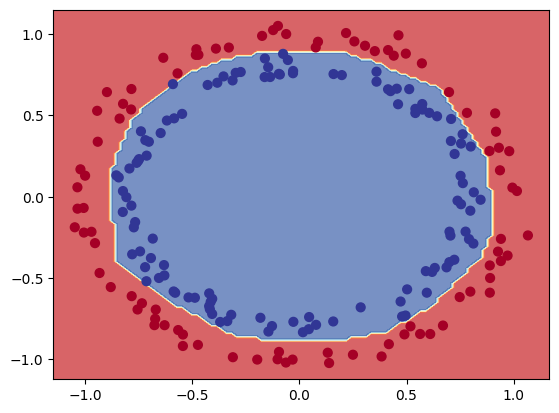

In [118]:
plot_decision_boundary(model1, X_test, y_test)